<a href="https://colab.research.google.com/github/therealellam/Offensive-Language-Hate-speech-classification-on-Twitter/blob/main/offensive_language_%26_hate_speech3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the dataset

In [ ]:
# Importing the libraries we will use
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import losses
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# These are the user defined functions that we will use

# This tells us how many row and columns our dataset has
#
def rows_and_columns(df):
  return print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')

# A table showing the percentage of missing values per column
#
def percent_missing_values(df):
  # Creating a dataframe showing percentage of missing values
  percentage = ((df.isnull().sum() / len(df)) * 100).sort_values(ascending=False).to_frame()

  # Renaming the column
  percentage.columns = ['Percentage Missing']

  # Returning a dataframe with the percentage of missing values
  return percentage[percentage['Percentage Missing'] > 0]

# Checking and dropping duplicate values
#
def duplicated_records(df):

  # Number of duplicates
  duplicates = df.duplicated().sum()

  # Checking if there are duplicated values
  if df.duplicated().any() == True:

  # Dropping duplicates if found 
    df.drop_duplicates(inplace=True)
    return(f'{duplicates} duplicates dropped')
  
  # Print no duplicates if there are none
  else:
    return print('No duplicated records')

# A function that standardizes text 
def custom_standardization(string):
  # To replace lots of whitespace with one
  new_string = re.sub('\s+', ' ', string)

  # To remove mentions
  new_string = re.sub('@[\w]+', '', new_string)

  # To remove urls
  new_string = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', new_string)

  # To remove hashtags
  new_string = re.sub('#[\w\-]+', '', new_string)

  # To remove punctuation marks
  new_string = re.sub('[^\w\s]', '', new_string)

  # To make the text lower case
  new_string = new_string.lower()

  return new_string

# A function that removes stopwords such the, a, as etc.
def remove_stopwords(tweet):
  return " ".join([word for word in tweet.split() if word not in stopwords])

In [ ]:
url = 'https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv'
# Loading our dataset
tweets = pd.read_csv(url)

# Previewing our dataset

In [ ]:
# Checking number of records
rows_and_columns(tweets)

The dataset has 24783 rows and 7 columns


In [ ]:
# Previewing the top of our dataset
tweets.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
# Previewing the bottom of our dataset
tweets.tail()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies
24782,25296,3,0,0,3,2,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...


# Exploratory Data Analysis

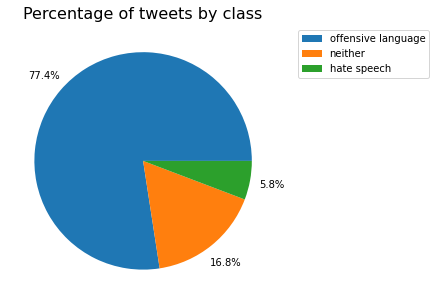

In [ ]:
# Finding the count per class
class_count = tweets['class'].value_counts()
index_ = ['offensive language', 'neither', 'hate speech']
class_count.index = index_

# A pie chart showing the percentage of tweets by class
plt.figure(figsize=(8,5))
plt.pie(x=class_count.values, autopct='%1.1f%%', pctdistance=1.2)
plt.legend(class_count.index, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('Percentage of tweets by class', fontsize = 16)
plt.show()

A majority of our tweets are classified as offensive language. Tweets classified as hate speech are the least

In [ ]:
# Creating a new column to show the length of a tweet
tweets['length'] = tweets['tweet'].apply(lambda x: len(x.split()))
tweets.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,length
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,25
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,16
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,21
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,9
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,26


In [ ]:
# Finding the median lenght of a tweet by class
hp_length = tweets[tweets['class'] == 0]['length'].median()
ol_length = tweets[tweets['class'] == 1]['length'].median()
neither_length = tweets[tweets['class'] == 2]['length'].median()
print(f'The median length of a tweet classified as hate speech is {hp_length}')
print(f'The median length of a tweet classified as offensive language is {ol_length}')
print(f'The median length of a tweet classified as neither is {neither_length}')

The median length of a tweet classified as hate speech is 13.5
The median length of a tweet classified as offensive language is 13.0
The median length of a tweet classified as neither is 15.0


# Preprocessing

In [ ]:
# Checking for issing values
percent_missing_values(tweets)

,Percentage Missing


In [ ]:
# Duplicates
duplicated_records(tweets)

No duplicated records


In [ ]:
# Removing columns we will not use
tweets.drop(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'], axis=1, inplace=True)

In [ ]:
# Removing mentions, hashtags, urls, lots of whitespace, punctuations from our tweets and lowercasing them
tweets['tweet'] = tweets['tweet'].apply(lambda tweet: custom_standardization(tweet))
tweets['tweet'].head()

0     rt  as a woman you shouldnt complain about cl...
1     rt  boy dats coldtyga dwn bad for cuffin dat ...
2     rt  dawg rt  you ever fuck a bitch and she st...
3                          rt   she look like a tranny
4     rt  the shit you hear about me might be true ...
Name: tweet, dtype: object

In [ ]:
# Removing stop words such as the, I, me etc.from our tweets
stopwords = set(stopwords.words('english'))
tweets['tweet'] = tweets['tweet'].apply(lambda tweet: remove_stopwords(tweet))
tweets['tweet'].head()

0    rt woman shouldnt complain cleaning house amp ...
1    rt boy dats coldtyga dwn bad cuffin dat hoe 1s...
2    rt dawg rt ever fuck bitch start cry confused ...
3                                  rt look like tranny
4    rt shit hear might true might faker bitch told ya
Name: tweet, dtype: object

In [ ]:
# Tokenizing - dividing strings into list of words
tweets['tweet'] = tweets['tweet'].apply(nltk.word_tokenize)
tweets['tweet'].head()

0    [rt, woman, shouldnt, complain, cleaning, hous...
1    [rt, boy, dats, coldtyga, dwn, bad, cuffin, da...
2    [rt, dawg, rt, ever, fuck, bitch, start, cry, ...
3                             [rt, look, like, tranny]
4    [rt, shit, hear, might, true, might, faker, bi...
Name: tweet, dtype: object

In [ ]:
# Stemming - reducing a word to its word stem
stemmer = PorterStemmer()
tweets['tweet'] = tweets['tweet'].apply(lambda x: [stemmer.stem(y) for y in x])
tweets['tweet'].head()

0    [rt, woman, shouldnt, complain, clean, hous, a...
1    [rt, boy, dat, coldtyga, dwn, bad, cuffin, dat...
2    [rt, dawg, rt, ever, fuck, bitch, start, cri, ...
3                             [rt, look, like, tranni]
4    [rt, shit, hear, might, true, might, faker, bi...
Name: tweet, dtype: object

In [ ]:
# Lemmatizing - same as stemming but context is taken into consideration for example - am : be, having - have
lem = WordNetLemmatizer()
tweets['tweet'] = tweets['tweet'].apply(lambda x: [lem.lemmatize(y) for y in x])
tweets['tweet'].head()

0    [rt, woman, shouldnt, complain, clean, hous, a...
1    [rt, boy, dat, coldtyga, dwn, bad, cuffin, dat...
2    [rt, dawg, rt, ever, fuck, bitch, start, cri, ...
3                             [rt, look, like, tranni]
4    [rt, shit, hear, might, true, might, faker, bi...
Name: tweet, dtype: object

In [ ]:
# Join the words to form a complete string
tweets['tweet'] = tweets['tweet'].apply(lambda tweet: ' '.join(tweet))
tweets['tweet'].head()

0    rt woman shouldnt complain clean hous amp man ...
1    rt boy dat coldtyga dwn bad cuffin dat hoe 1st...
2     rt dawg rt ever fuck bitch start cri confus shit
3                                  rt look like tranni
4    rt shit hear might true might faker bitch told ya
Name: tweet, dtype: object

In [ ]:
# Label Encoding our class column using pd.getdummies
# class_0 - hatespeech, class_1 = offensive language, class_2 = neither
tweets = pd.get_dummies(tweets, columns=['class'])
tweets.head()

,tweet,length,class_0,class_1,class_2
0,rt woman shouldnt complain clean hous amp man ...,25,0,0,1
1,rt boy dat coldtyga dwn bad cuffin dat hoe 1st...,16,0,1,0
2,rt dawg rt ever fuck bitch start cri confus shit,21,0,1,0
3,rt look like tranni,9,0,1,0
4,rt shit hear might true might faker bitch told ya,26,0,1,0


In [ ]:
# Separating our dependent and independent variables
X = tweets['tweet']
y = tweets.drop(['tweet', 'length'], axis=1)

In [ ]:
# Tokenizing to assign each word a unique id and only returning the 3000 most common words
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(X)
sequence = tokenizer.texts_to_sequences(X)

In [ ]:
# Padding - neural networks require the input sequence data with the same length 
sequence_matrix = pad_sequences(sequence, maxlen = 280)

In [ ]:
# Splitting our dataset into training and testing datasets
X_train, X_test, Y_train, Y_test = train_test_split(sequence_matrix, y, test_size=0.1, random_state=0)

# Modelling

In [ ]:
# Building our neural network layer by layer
# 1st layer is embedding which converts words into vectors to enable the machine to calculate similarity
# The 2nd layer is long short term memory which save the words and enables the model to predict the next words based on the previous words
# The 3rd layer has 256 nodes and is activated using 'relu'
# Then we drop out 20% of the nodes to prevent overfitting
# The last layer is our output layer with 3 nodes for our three classes, with activation 'sigmoid'
model = tf.keras.Sequential([
  layers.Embedding(3000,50, input_length=280),
  layers.LSTM(64),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(3, activation = 'sigmoid')
  ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 50)           150000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 196,851
Trainable params: 196,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Configuring our model with the categorical cross entropy loss function, and using adam optimzer
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=["CategoricalAccuracy"])

In [ ]:
# Training the model
history = model.fit(X_train, Y_train, batch_size=80, epochs=6, validation_split=0.1)

Epoch 1/6
251/251 [==============================] - 65s 250ms/step - loss: 0.4782 - categorical_accuracy: 0.8319 - val_loss: 0.3157 - val_categorical_accuracy: 0.8875
Epoch 2/6
251/251 [==============================] - 63s 249ms/step - loss: 0.2612 - categorical_accuracy: 0.9083 - val_loss: 0.2727 - val_categorical_accuracy: 0.9032
Epoch 3/6
251/251 [==============================] - 62s 249ms/step - loss: 0.2104 - categorical_accuracy: 0.9236 - val_loss: 0.2900 - val_categorical_accuracy: 0.8938
Epoch 4/6
251/251 [==============================] - 62s 249ms/step - loss: 0.1876 - categorical_accuracy: 0.9327 - val_loss: 0.3074 - val_categorical_accuracy: 0.8942
Epoch 5/6
251/251 [==============================] - 62s 247ms/step - loss: 0.1698 - categorical_accuracy: 0.9381 - val_loss: 0.3259 - val_categorical_accuracy: 0.8933
Epoch 6/6
251/251 [==============================] - 62s 248ms/step - loss: 0.1546 - categorical_accuracy: 0.9418 - val_loss: 0.3798 - val_categorical_accuracy:

In [ ]:
# Evaluating our model's performance using the testing data
accr1 = model.evaluate(X_test,Y_test)

78/78 [==============================] - 3s 36ms/step - loss: 0.3898 - categorical_accuracy: 0.8822


In [ ]:
# Plotting the training and validation loss and accuracy per epoch for comparison
history_dict = history.history
history_dict.keys()

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

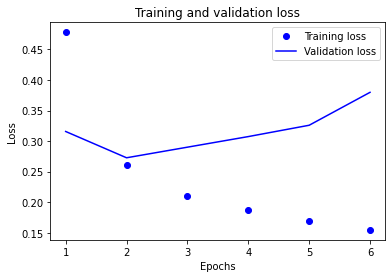

In [ ]:
# Training and validation loss per epoch
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

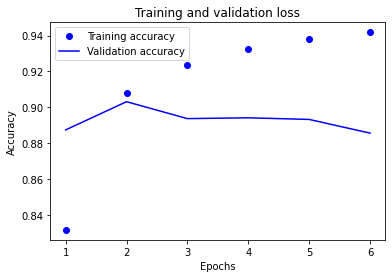

In [ ]:
# Plotting training and validation accuracy per epoch
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

After 2 epochs our model performs worse and worse on the validation dataset, a sign of overfitting. Therefore we will only train our model with 2 epochs

In [ ]:
# Training our model with 2 epochs
history1 = model.fit(X_train, Y_train, batch_size=80, epochs=2, validation_split=0.1)

Epoch 1/2
251/251 [==============================] - 59s 227ms/step - loss: 0.4805 - categorical_accuracy: 0.8295 - val_loss: 0.3123 - val_categorical_accuracy: 0.8906
Epoch 2/2
251/251 [==============================] - 56s 223ms/step - loss: 0.2583 - categorical_accuracy: 0.9068 - val_loss: 0.2661 - val_categorical_accuracy: 0.9081


In [ ]:
# Evaluating the accuracy of our model
accr2 = model.evaluate(X_test,Y_test)

78/78 [==============================] - 3s 33ms/step - loss: 0.2939 - categorical_accuracy: 0.8947


In [ ]:
# Predicting the class of our datasets
# .predict returns the probability of a tweet belonging to a class
y_pred_prob  = model.predict(X_test)
y_pred_prob

array([[0.2175903 , 0.2519356 , 0.86038935],
       [0.19673431, 0.98820126, 0.04406464],
       [0.11801383, 0.97550803, 0.13448799],
       ...,
       [0.07027709, 0.9682878 , 0.24184847],
       [0.19944334, 0.9440767 , 0.16804725],
       [0.38261724, 0.9907752 , 0.01395032]], dtype=float32)

In [ ]:
# To get the class of the tweet we find the index of the maximum probability per row
# So index - 0 is hatespeech, 1 is offensive language and 2 is neither
y_pred_class = np.argmax(y_pred_prob, axis=1)
y_pred_class

array([2, 1, 1, ..., 1, 1, 1])

In [ ]:
Y_test.head()

,class_0,class_1,class_2
4129,0,0,1
15081,0,1,0
16547,0,1,0
4273,1,0,0
4254,0,0,1


In [ ]:
# Creating an array of the correct labels from our Y_test
y_test = Y_test.idxmax(axis=1).values
conditions =[
             y_test == 'class_0',
             y_test == 'class_1',
             y_test == 'class_2'
]
values = [0, 1, 2]

y_test = np.select(conditions, values)
y_test

array([2, 1, 1, ..., 1, 1, 1])

In [ ]:
# Creating a confusion matrix to evaluate the performance of our model
conf_matrix = confusion_matrix(y_test, y_pred_class)
print(conf_matrix)

[[  32   98   15]
 [  32 1830   66]
 [   2   48  356]]


In [ ]:
# Classification report
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.48      0.22      0.30       145
           1       0.93      0.95      0.94      1928
           2       0.81      0.88      0.84       406

    accuracy                           0.89      2479
   macro avg       0.74      0.68      0.70      2479
weighted avg       0.88      0.89      0.89      2479



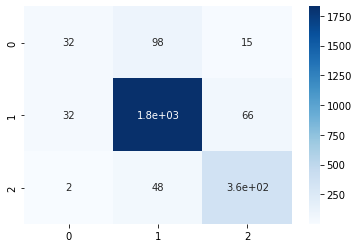

In [ ]:
# Visualization
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.savefig('conf_matrix.png')
plt.show()

# Deployment

In [ ]:
# Loading our scrapped tweets into a datasest for deploying
deploy = pd.read_csv('/content/test_data_another.csv')

In [ ]:
# Previewing the top of our dataset
deploy.head()

,index,tweet
0,1,As of being a bitch to (Cheryl) because I cann...
1,2,when pH-1 said sick and tired off hearing all ...
2,3,Its pretty simple; get vaxxed or prepare to ge...
3,4,No but like imagine a complete stranger giving...
4,5,Unless you eitherWere alive & aware during the...


In [ ]:
deploy.shape

(357, 2)

In [ ]:
# Dropping the first column as it is unnecessary
deploy.drop(deploy.iloc[:,0:1], axis=1, inplace=True)

In [ ]:
# Creating a copy for later user
copy_deploy = deploy.copy()

To be able to fees our tweets into the model we first need to process them into a format that is acceptable

In [ ]:
# Removing mentions, hashtags, urls, lots of whitespace, punctuations from our tweets and lowercasing them
deploy['tweet'] = deploy['tweet'].apply(lambda tweet: custom_standardization(tweet))
deploy['tweet'].head()

0    as of being a bitch to cheryl because i cannot...
1    when ph1 said sick and tired off hearing all u...
2    its pretty simple get vaxxed or prepare to get...
3    no but like imagine a complete stranger giving...
4    unless you eitherwere alive  aware during the ...
Name: tweet, dtype: object

In [ ]:
# Removing stop words such as the, I, me etc.from our tweets
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
deploy['tweet'] = deploy['tweet'].apply(lambda tweet: remove_stopwords(tweet))
deploy['tweet'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    bitch cheryl cannot die stab eye hurts instead...
1    ph1 said sick tired hearing ur lies stop last ...
2    pretty simple get vaxxed prepare get sick die ...
3    like imagine complete stranger giving child fu...
4    unless eitherwere alive aware periodorhave adv...
Name: tweet, dtype: object

In [ ]:
# Tokenizing - dividing strings into lists of substrings
deploy['tweet'] = deploy['tweet'].apply(nltk.word_tokenize)
deploy['tweet'].head()

0    [bitch, cheryl, can, not, die, stab, eye, hurt...
1    [ph1, said, sick, tired, hearing, ur, lies, st...
2    [pretty, simple, get, vaxxed, prepare, get, si...
3    [like, imagine, complete, stranger, giving, ch...
4    [unless, eitherwere, alive, aware, periodorhav...
Name: tweet, dtype: object

In [ ]:
# Stemming - reducing a word to its word stem
stemmer = PorterStemmer()
deploy['tweet'] = deploy['tweet'].apply(lambda x: [stemmer.stem(y) for y in x])
deploy['tweet'].head()

0    [bitch, cheryl, can, not, die, stab, eye, hurt...
1    [ph1, said, sick, tire, hear, ur, lie, stop, l...
2    [pretti, simpl, get, vax, prepar, get, sick, d...
3    [like, imagin, complet, stranger, give, child,...
4    [unless, eitherwer, aliv, awar, periodorhav, a...
Name: tweet, dtype: object

In [ ]:
# Lemmatizing - same as stemming but context is taken into consideration for example - am : be, having - have
lem = WordNetLemmatizer()
deploy['tweet'] = deploy['tweet'].apply(lambda x: [lem.lemmatize(y) for y in x])

deploy['tweet'].head()

0    [bitch, cheryl, can, not, die, stab, eye, hurt...
1    [ph1, said, sick, tire, hear, ur, lie, stop, l...
2    [pretti, simpl, get, vax, prepar, get, sick, d...
3    [like, imagin, complet, stranger, give, child,...
4    [unless, eitherwer, aliv, awar, periodorhav, a...
Name: tweet, dtype: object

In [ ]:
# Join the words to form a complete string
deploy['tweet'] = deploy['tweet'].apply(lambda tweet: ' '.join(tweet))
deploy['tweet'].head()

0    bitch cheryl can not die stab eye hurt instead...
1    ph1 said sick tire hear ur lie stop last time ...
2    pretti simpl get vax prepar get sick die healt...
3    like imagin complet stranger give child fuck t...
4    unless eitherwer aliv awar periodorhav advanc ...
Name: tweet, dtype: object

In [ ]:
# Tokenizing - we assign the words on a tweet to the unique ids we created earlier during training 
# i.e. the words our model knows
d_sequence = tokenizer.texts_to_sequences(deploy['tweet'])

In [ ]:
# Padding to make the lengths equal
d_sequence_matrix = pad_sequences(d_sequence, maxlen = 280)

In [ ]:
# Predicting the class of our tweets using the model we trained
# .predict returns probabilities of belonging to a class
d_pred_prob = model.predict(d_sequence_matrix)
d_pred_prob

array([[0.07180852, 0.8468083 , 0.59080654],
       [0.3334673 , 0.91592956, 0.14395499],
       [0.12977779, 0.6715316 , 0.68566245],
       ...,
       [0.2463178 , 0.2788871 , 0.828205  ],
       [0.20070285, 0.7575251 , 0.4969648 ],
       [0.06791207, 0.7596811 , 0.7086076 ]], dtype=float32)

In [ ]:
# Getting the class by finding out the index of the maximum probability 
# So index - 0 is hatespeech, 1 is offensive language and 2 is neither
d_pred_class = np.argmax(d_pred_prob, axis=1)
d_pred_class

array([1, 1, 2, 1, 2, 2, 0, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2,
       1, 1, 2, 2, 2, 1, 1, 1, 1, 0, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1,
       2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1,
       2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1,
       2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2,
       1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1,
       1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2,
       2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1,
       1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2,
       2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2,
       1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2,

In [ ]:
# Creating a new column with the predicted class of our tweet
copy_deploy['predicted_class'] = d_pred_class
copy_deploy.head()

,tweet,predicted_class
0,As of being a bitch to (Cheryl) because I cann...,1
1,when pH-1 said sick and tired off hearing all ...,1
2,Its pretty simple; get vaxxed or prepare to ge...,2
3,No but like imagine a complete stranger giving...,1
4,Unless you eitherWere alive & aware during the...,2


In [ ]:
# Creating another column with the predicted class but this time with the string rather than the nnumber
conditions = [
              copy_deploy['predicted_class'] == 0,
              copy_deploy['predicted_class'] == 1,
              copy_deploy['predicted_class'] == 2
]
# 0 = hatespeech, 1 = offensive language, 2 = neither
values = ['hatespeech', 'offensive language', 'neither']

# 
copy_deploy['predicted_class_str'] = np.select(conditions, values)
copy_deploy.head()

,tweet,predicted_class,predicted_class_str
0,As of being a bitch to (Cheryl) because I cann...,1,offensive language
1,when pH-1 said sick and tired off hearing all ...,1,offensive language
2,Its pretty simple; get vaxxed or prepare to ge...,2,neither
3,No but like imagine a complete stranger giving...,1,offensive language
4,Unless you eitherWere alive & aware during the...,2,neither


In [ ]:
# Looking at some tweets per class
copy_deploy[copy_deploy['predicted_class_str'] == 'offensive language']

,tweet,predicted_class,predicted_class_str
0,As of being a bitch to (Cheryl) because I cann...,1,offensive language
1,when pH-1 said sick and tired off hearing all ...,1,offensive language
3,No but like imagine a complete stranger giving...,1,offensive language
8,"Yeah, ""Lets all keep COVID flourishing n mutat...",1,offensive language
11,This nigga always tell me imma problem baby I...,1,offensive language
...,...,...,...
347,I don't give a flying fuck if I die for erasin...,1,offensive language
348,Me as the sea lion I ain't goin NOWHERE!! I ne...,1,offensive language
353,If your an adult and not vaccinated if you ge...,1,offensive language
355,"Celebrities that you like, that die aren’t pro...",1,offensive language


In [ ]:
# Printing a tweet and its class
print(copy_deploy.iloc[172,0])
print(copy_deploy.iloc[172,-1])

1 thing for sure its not 1 bitch walking the face of this earth that can say I ever reached out to reconcile or squash a bitch ass thing yall kno I love a grudge like you could go die and I wont give 2 fucks dont ever play with me
offensive language


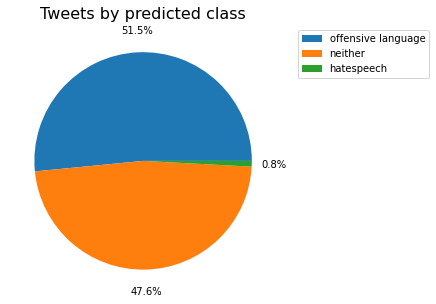

In [ ]:
# Pie chart showing tweets by class
plt.figure(figsize=(8,5))
plt.pie(x=copy_deploy['predicted_class_str'].value_counts().values, autopct='%1.1f%%', pctdistance=1.2)
plt.legend(copy_deploy['predicted_class_str'].value_counts().index, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('Tweets by predicted class', fontsize = 16)
plt.savefig('Tweets by predicted class.png')
plt.show()

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def classify():
  tweet = input("What's the tweet? ")
  # Removing mentions, hashtags, urls, lots of whitespace, punctuations from our tweets and lowercasing them
  tweet = custom_standardization(tweet)

  # Removing stopwords
  tweet = remove_stopwords(tweet)

  # Tokenizing - dividing strings into lists of substrings
  # tweet = nltk.word_tokenize(tweet)

  # Stemming
  tweet = stemmer.stem(tweet)

  # Lemmatizing
  tweet = lem.lemmatize(tweet)

  # 
  # tweet = ' '.join(tweet)
  
  # 
  sequence = tokenizer.texts_to_sequences([tweet])
  
  # Padding
  sequence_matrix = pad_sequences(sequence, maxlen = 280)

  # Predicting
  pred_prob = model.predict(sequence_matrix)

  # Finding the class
  pred_class = np.argmax(pred_prob)

  if pred_class == 0:
    tweet_class = 'hate speech'

  elif pred_class == 1:
    tweet_class = 'offensive'
  
  elif pred_class == 2:
    tweet_class = 'neither'
  
  return print('This tweet is ', tweet_class)

In [ ]:
classify()

What's the tweet? Samwel Should mobilize people to strike and avoid 
This tweet is  offensive
